Link shadowing losses:
Link N0 ↔ N1: Shadowing Loss = 0.98 dB, Distance = 85.49 m
Link N0 ↔ N2: Shadowing Loss = 5.69 dB, Distance = 73.94 m
Link N0 ↔ N3: Shadowing Loss = 3.63 dB, Distance = 59.35 m
Link N0 ↔ N4: Shadowing Loss = 2.63 dB, Distance = 105.86 m
Link N1 ↔ N2: Shadowing Loss = 2.81 dB, Distance = 75.72 m
Link N1 ↔ N3: Shadowing Loss = 0.75 dB, Distance = 59.22 m
Link N1 ↔ N4: Shadowing Loss = -0.25 dB, Distance = 61.77 m
Link N2 ↔ N3: Shadowing Loss = 5.32 dB, Distance = 20.39 m
Link N2 ↔ N4: Shadowing Loss = 4.45 dB, Distance = 44.78 m
Link N3 ↔ N4: Shadowing Loss = 2.40 dB, Distance = 47.83 m


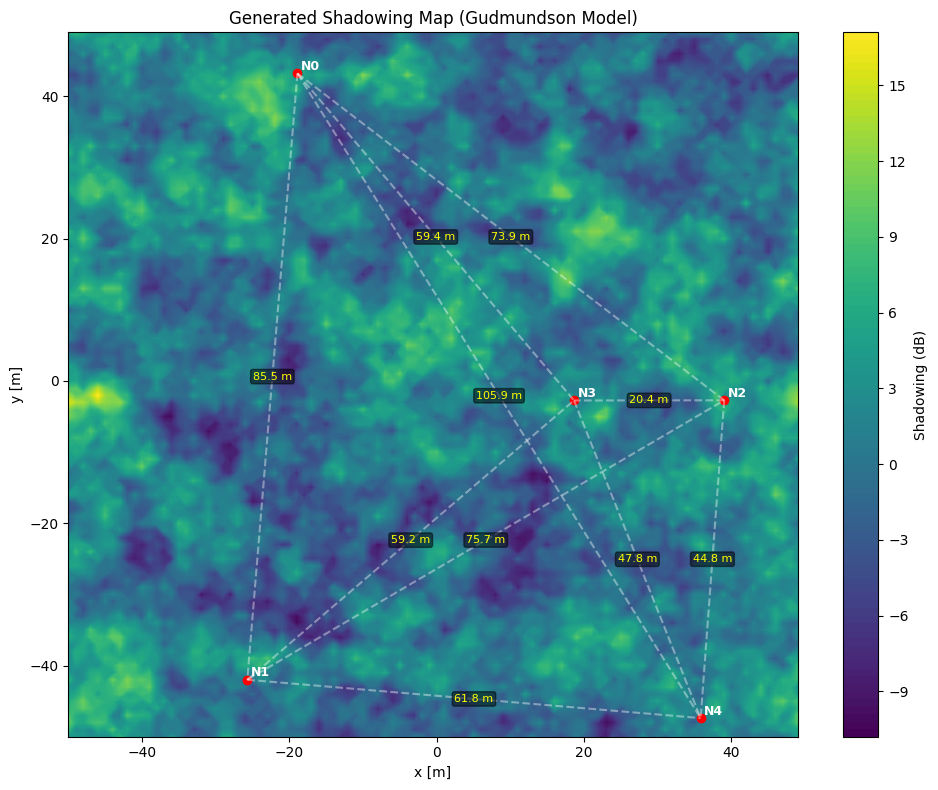


Shadowing map stats:
  Mean = 0.63 dB
  Std Dev = 3.76 dB (expected: 4 dB)

Shadowing values at individual nodes:
  Node N0 @ (-18.91, 43.23): Shadowing = 2.73 dB
  Node N1 @ (-25.71, -42.00): Shadowing = -1.34 dB
  Node N2 @ (39.03, -2.72): Shadowing = 5.31 dB
  Node N3 @ (18.64, -2.74): Shadowing = 2.40 dB
  Node N4 @ (35.83, -47.38): Shadowing = 0.99 dB


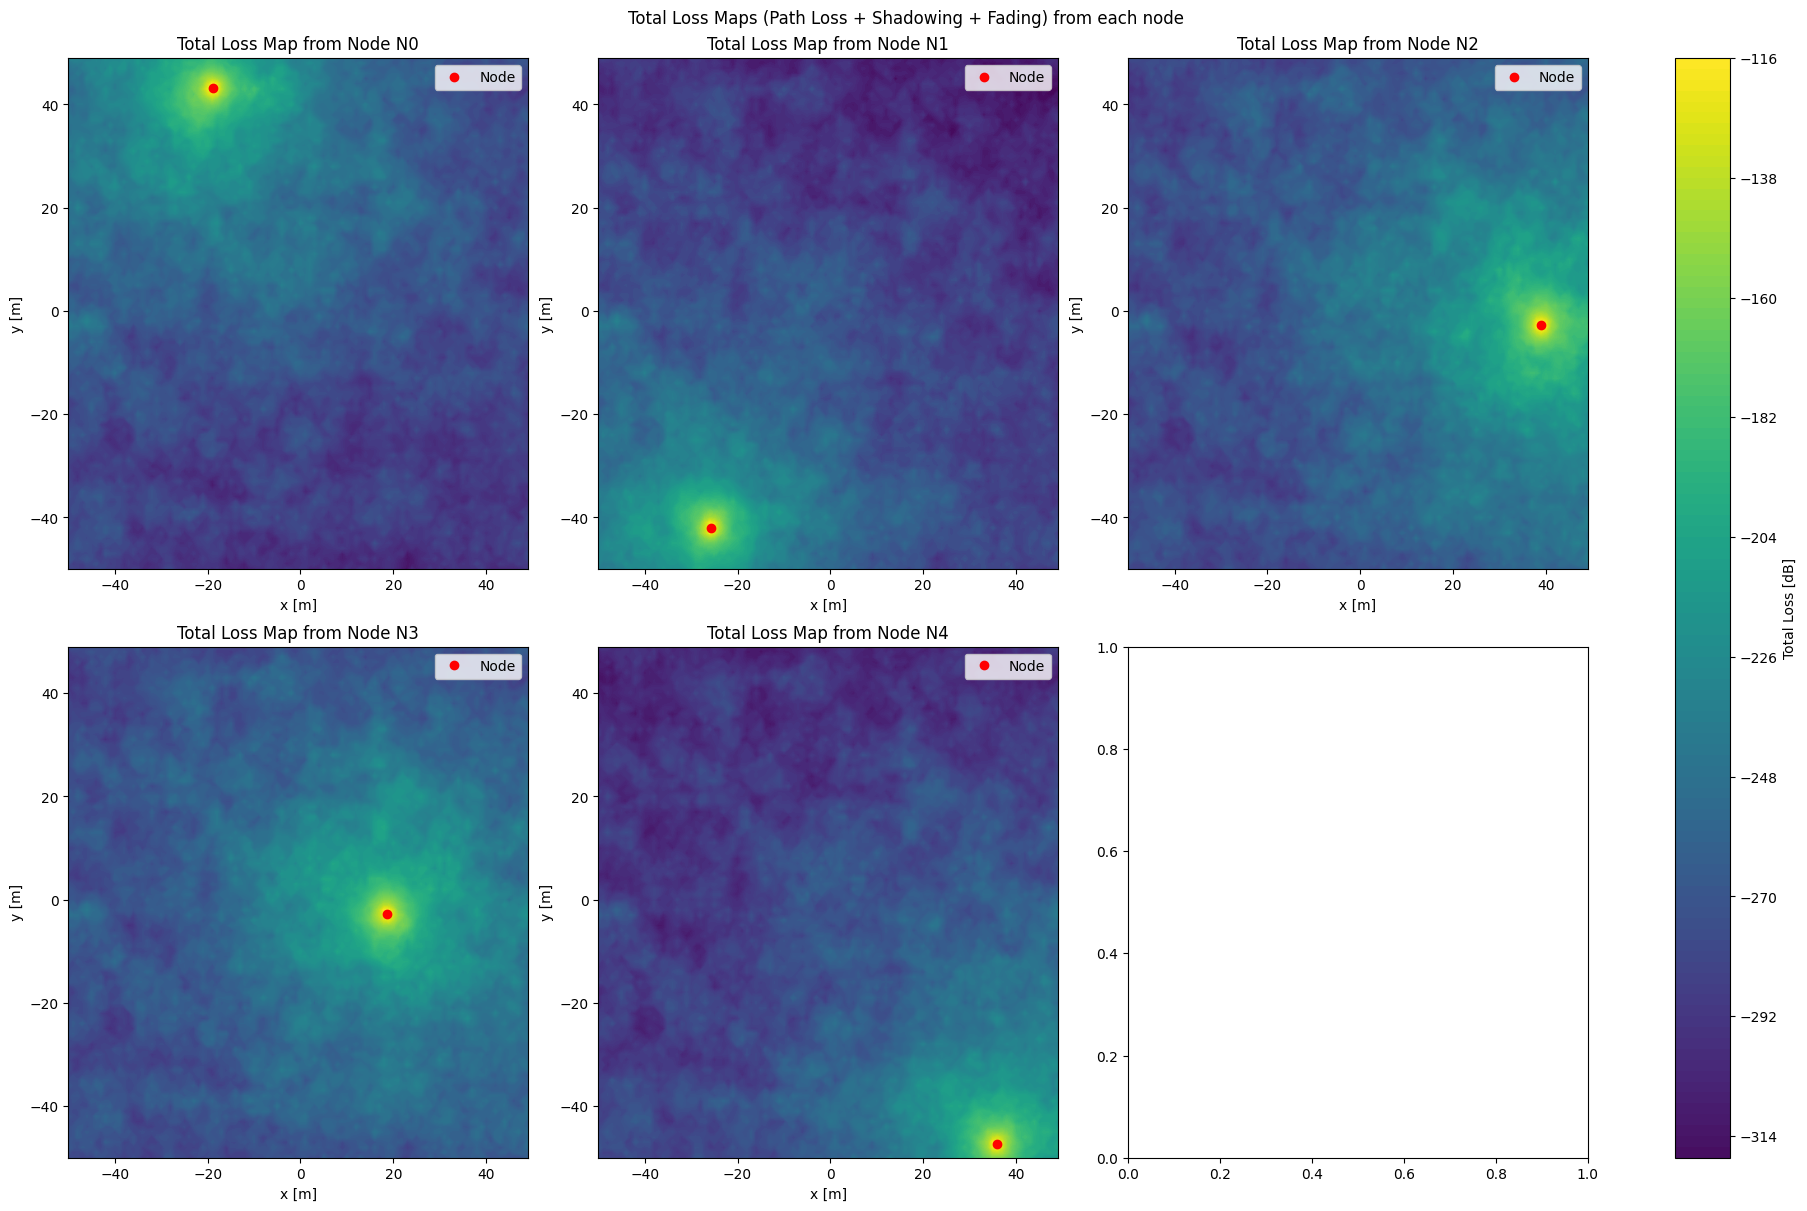

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# First, make the import manager happy
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.insert(0, project_root)

from simulator.models.topology import Topology, CartesianCoordinate
from simulator.models.ChannelModel import ChannelModel

# === Set global seed ===
np.random.seed(31)

# === Setup topology and channel ===
topology = Topology(
    dspace_step=1,     # grid step 1 meter
    dspace_npt=100     # 100x100 grid points
)

model = ChannelModel(
    topology=topology,
    freq=2.4e9,            # typical for indoor WSN (WiFi, ZigBee)
    coh_d=5,               # shorter shadowing coherence indoor (5 m)
    shadow_dev=4,          # typical indoor shadowing deviation (3-6 dB)
    pl_exponent=3,         # indoor path loss exponent (2.7-4)
    d0=1,                  # reference distance
    fading_shape=10.0,     # lower fading shape indoor (Rayleigh/Nakagami, typical 1-10)
    #fading_scale=1.0      # optional
)

model.generate_shadowing_map()
shadowing_map = model.shadowing_map
X, Y = topology.X, topology.Y

# === Sample random points in the map ===
n_points = 5
raw_points = np.random.uniform(-topology._size/2, topology._size/2, size=(n_points, 2))
points = [CartesianCoordinate(x, y) for x, y in raw_points]

# === Plot shadowing map and nodes ===
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, shadowing_map, levels=100, cmap='viridis')
plt.colorbar(label='Shadowing (dB)')
plt.title("Generated Shadowing Map (Gudmundson Model)")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

for idx, pt in enumerate(points):
    plt.plot(pt.x, pt.y, 'ro')
    plt.text(pt.x + 0.5, pt.y + 0.5, f"N{idx}", color='white', fontsize=9, weight='bold')

# Draw links, print shadowing loss, and annotate distance
print("Link shadowing losses:")
for i in range(n_points):
    for j in range(i+1, n_points):
        A, B = points[i], points[j]
        loss = model._link_shadowing_loss(A, B)
        plt.plot([A.x, B.x], [A.y, B.y], color='white', alpha=0.4, linestyle='--')
        # Calculate and annotate distance
        dist = np.hypot(B.x - A.x, B.y - A.y)
        mid_x = (A.x + B.x) / 2
        mid_y = (A.y + B.y) / 2
        plt.text(mid_x, mid_y, f"{dist:.1f} m", color='yellow', fontsize=8, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
        print(f"Link N{i} ↔ N{j}: Shadowing Loss = {loss:.2f} dB, Distance = {dist:.2f} m")

plt.tight_layout()
plt.show()

# === Global shadowing stats ===
print(f"\nShadowing map stats:")
print(f"  Mean = {np.mean(shadowing_map):.2f} dB")
print(f"  Std Dev = {np.std(shadowing_map):.2f} dB (expected: {model.shadow_dev} dB)")

# === Local shadowing at nodes ===
print("\nShadowing values at individual nodes:")
for idx, pt in enumerate(points):
    val = model._shadowing_power_on_point(pt)
    print(f"  Node N{idx} @ ({pt.x:.2f}, {pt.y:.2f}): Shadowing = {val:.2f} dB")

# === Now create the total loss maps from each node using ChannelModel function ===
# Calculate the number of rows and columns based on the number of nodes
n_cols = int(np.ceil(np.sqrt(n_points)))
n_rows = int(np.ceil(n_points / n_cols))

# Calculate global scale for all total loss maps
min_loss, max_loss = np.inf, -np.inf
total_loss_maps = []
for node in points:
    tl_map = model.total_loss_from_point(node)
    total_loss_maps.append(tl_map)
    min_loss = min(min_loss, np.min(tl_map))
    max_loss = max(max_loss, np.max(tl_map))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), constrained_layout=True)
axs = axs.flatten()

# Use a single global colorbar for all subplots
ims = []
for idx, node in enumerate(points):
    im = axs[idx].contourf(X, Y, total_loss_maps[idx], levels=100, cmap='viridis', vmin=min_loss, vmax=max_loss)
    axs[idx].set_title(f"Total Loss Map from Node N{idx}")
    axs[idx].plot(node.x, node.y, 'ro', markersize=6, label='Node')
    axs[idx].legend()
    axs[idx].set_xlabel('x [m]')
    axs[idx].set_ylabel('y [m]')
    ims.append(im)

# Global colorbar
fig.colorbar(ims[0], ax=axs, orientation='vertical', label='Total Loss [dB]')

plt.suptitle("Total Loss Maps (Path Loss + Shadowing + Fading) from each node")
plt.show()

